## Продолжение экспериментов
* ноутбук #03

* этот ноутбук вдохновлён:

    * Елена на лекции сказала, что класска - это `бустинг + optuna`

    * AutoMl показал на `HistGradientBoostingClassifier`, хотя и не побил качество наших моделей

* Затем можно попробоавть `GradientBoostingClassifier`

In [1]:
# pip install optuna -q

In [2]:
import optuna
import optuna.visualization as oviz

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

np.random.seed(691)
random_state = 326
DATA_FOLDER = "data/"

/home/ana/anaconda3/envs/year_pj_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay

In [4]:
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from typing import Tuple

def get_metrics(y_pred, y_true, rounding=8, verbouse=True, returns=False) -> Tuple:
    """Print/Return all metrics by predictions and true values""" 

    if returns == True:
        verbouse = False

    acc = np.round(balanced_accuracy_score(y_pred, y_true), rounding)
    f1 = np.round(f1_score(y_pred, y_true, average="weighted"), rounding)
    
    y_true_binarized = label_binarize(y_true, classes=[0, 1, 2])
    y_pred_binarized = label_binarize(y_pred, classes=[0, 1, 2])

    # Расчет ROC-AUC для многоклассовой задачи
    auc_score = roc_auc_score(y_true_binarized, y_pred_binarized,
                            multi_class='ovr', average=None)

    roc_auc_metric = y.value_counts(sort=False, normalize=True) @ auc_score[::-1]
    roc_auc_metric = np.round(roc_auc_metric, rounding)
    gini = 2 * roc_auc_metric - 1
    gini = np.round(gini, rounding)

    if verbouse:
        print(f"Balanced accuracy: {acc}")
        print(f"F1-score: {f1}")
        print(f"roc_auc_score: {roc_auc_metric}")
        print(f"gini_score:{gini}")

    if returns:
        return acc, f1, roc_auc_metric, gini
    

## Модель подобраная AutoML

```python
HistGradientBoostingClassifier(early_stopping=True, 
                               l2_regularization=3.169e-10,
                               learning_rate=0.0071896160622,
                               max_features=0.4192551914042,
                               max_leaf_nodes=1998, 
                               min_samples_leaf=50,
                               n_iter_no_change=19, 
                               random_state=326,
                               tol=0.0001, 
                               validation_fraction=None)
```

## Обучим базу (без подбора параметров)

In [5]:
df_images = pd.read_csv(DATA_FOLDER + "data_FEB25_SVD_eq_sample_128_5000.csv").iloc[:, 1:]
print(f"Размер выборки: {df_images.shape[0]}")

X, y = df_images.drop(columns="class"), df_images["class"]
X.head(4)

Размер выборки: 5001


,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,-6223,9927,3067,21008,-29338,-10909,1422,4398,425,-6796,...,1315,405,1050,-1212,373,105,-413,-286,152,1342
1,36388,32262,18336,1356,7981,-9171,-3858,-7075,-15646,-4055,...,228,-382,404,-247,205,-28,-2351,-240,-1443,-801
2,-23148,20247,218,11207,5652,3891,16990,7596,-2685,6401,...,-2723,613,550,282,340,521,2654,-809,-976,-63
3,-30978,12287,-23751,-123,6314,14986,-3674,1458,-3767,2653,...,93,775,-141,228,2113,-364,-1409,341,997,559


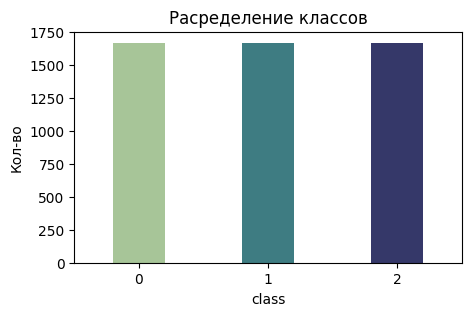

In [6]:
plt.figure(figsize = (5, 3))
sns.countplot(x=y, hue=y, legend=False, palette='crest', width=0.4,)
plt.title("Расределение классов")
plt.ylabel("Кол-во");

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

In [8]:
HistGB = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', HistGradientBoostingClassifier(random_state=random_state))
])

HistGB.fit(X_train, y_train)

y_pred_HistGB = HistGB.predict(X_test)
get_metrics(y_pred_HistGB, y_test)

Balanced accuracy: 0.56811904
F1-score: 0.58380573
roc_auc_score: 0.68313165
gini_score:0.3662633


## Подбираем параметры optun-ой

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

In [10]:
from sklearn.metrics import log_loss

def evaluate_model(model):
    """Calc loss on val data"""
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=random_state, 
        stratify=y
    )

    scl = MinMaxScaler().fit(X_train)
    X_train = scl.transform(X_train)
    X_val = scl.transform(X_val)

    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_val)

    return log_loss(y_val, y_pred)

In [11]:
def objective(trial):
    lr = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    max_iter = trial.suggest_int('max_iter', 50, 500)
    max_depth = trial.suggest_int('max_depth', 10, 100)  # for each tree
    mf = trial.suggest_float('max_features', 0.1, 1)
    tol = trial.suggest_float('tol', 1e-7, 1e-2, log=True)
    
    model = HistGradientBoostingClassifier(
        random_state=random_state,
        early_stopping = True, 
        n_iter_no_change = 20,

        learning_rate=lr, 
        max_iter=max_iter, 
        max_depth = max_depth,
        max_features = mf,
        tol=tol,
    )
    return evaluate_model(model)

In [12]:
study = optuna.create_study(
    study_name="first_study",
    direction='minimize',
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.HyperbandPruner()
)

[I 2025-03-14 21:00:19,540] A new study created in memory with name: first_study


In [13]:
study.optimize(objective, n_trials=50, n_jobs=-1)

[I 2025-03-14 21:00:27,786] Trial 11 finished with value: 1.0979409492692103 and parameters: {'learning_rate': 6.86054788190348e-05, 'max_iter': 256, 'max_depth': 84, 'max_features': 0.8861635479071861, 'tol': 0.006717480028600249}. Best is trial 11 with value: 1.0979409492692103.
[I 2025-03-14 21:00:39,403] Trial 6 finished with value: 0.9159934051524016 and parameters: {'learning_rate': 0.01931505100201185, 'max_iter': 54, 'max_depth': 100, 'max_features': 0.8809259104066478, 'tol': 1.4273606921069373e-05}. Best is trial 6 with value: 0.9159934051524016.
[I 2025-03-14 21:00:40,280] Trial 4 finished with value: 0.8910199877884455 and parameters: {'learning_rate': 0.07371432084105642, 'max_iter': 73, 'max_depth': 17, 'max_features': 0.5375405588975161, 'tol': 3.009952137179233e-06}. Best is trial 4 with value: 0.8910199877884455.
[I 2025-03-14 21:00:46,195] Trial 1 finished with value: 0.9977327817276346 and parameters: {'learning_rate': 0.004783137820436953, 'max_iter': 66, 'max_depth

In [14]:
oviz.plot_param_importances(study)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

HistGB = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', HistGradientBoostingClassifier(
        random_state=random_state,
        early_stopping = True, 
        n_iter_no_change = 20, 
        **study.best_params, 
    ))
])

HistGB.fit(X_train, y_train)

y_pred_HistGB = HistGB.predict(X_test)
get_metrics(y_pred_HistGB, y_test)

Balanced accuracy: 0.57597021
F1-score: 0.59335259
roc_auc_score: 0.68988091
gini_score:0.37976182


In [16]:
study.best_params

{'learning_rate': 0.00812528817838329,
 'max_iter': 431,
 'max_depth': 67,
 'max_features': 0.17163516824020228,
 'tol': 9.304402125907366e-05}

## Второй виток

In [17]:
def objective02(trial):
    lr = trial.suggest_float('learning_rate', 1e-3, 1e-2, log=True)
    mf = trial.suggest_float('max_features', 0.25, 0.75)
    max_iter = trial.suggest_int('max_iter', 150, 350)
    max_depth = trial.suggest_int('max_depth', 40, 120)
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 10, 100)
    min_samples_leaf  = trial.suggest_int('min_samples_leaf', 10, 100)
    tol = trial.suggest_float('tol', 1e-5, 1e-4, log=True)
    
    model = HistGradientBoostingClassifier(
        random_state=random_state,
        early_stopping = True, 
        n_iter_no_change = 20,
        tol=tol,
        max_iter=max_iter,
        learning_rate=lr, 
        max_depth = max_depth,
        max_features = mf,
        max_leaf_nodes = max_leaf_nodes,
        min_samples_leaf = min_samples_leaf,
    )
    return evaluate_model(model)

In [18]:
study02 = optuna.create_study(
    study_name="second_study",
    direction='minimize',
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.HyperbandPruner()
)

[I 2025-03-14 21:05:51,059] A new study created in memory with name: second_study


In [19]:
study02.optimize(objective02, n_trials=50, n_jobs=-1, )

[I 2025-03-14 21:06:13,912] Trial 8 finished with value: 0.9144224427183444 and parameters: {'learning_rate': 0.006912634034418698, 'max_features': 0.4867956399901802, 'max_iter': 213, 'max_depth': 55, 'max_leaf_nodes': 10, 'min_samples_leaf': 82, 'tol': 2.8194378487582104e-05}. Best is trial 8 with value: 0.9144224427183444.
[I 2025-03-14 21:06:22,014] Trial 5 finished with value: 0.9707121681064693 and parameters: {'learning_rate': 0.0026742169002961654, 'max_features': 0.252725744345994, 'max_iter': 250, 'max_depth': 56, 'max_leaf_nodes': 12, 'min_samples_leaf': 79, 'tol': 1.1993145098341159e-05}. Best is trial 8 with value: 0.9144224427183444.
[I 2025-03-14 21:06:27,878] Trial 11 finished with value: 1.0347490570666977 and parameters: {'learning_rate': 0.0012098929938054923, 'max_features': 0.4261931839484402, 'max_iter': 157, 'max_depth': 118, 'max_leaf_nodes': 22, 'min_samples_leaf': 30, 'tol': 2.005187367809721e-05}. Best is trial 8 with value: 0.9144224427183444.
[I 2025-03-14 

In [20]:
oviz.plot_param_importances(study02)

In [21]:
study02.best_params

{'learning_rate': 0.00981648489656626,
 'max_features': 0.5695167607168201,
 'max_iter': 274,
 'max_depth': 40,
 'max_leaf_nodes': 100,
 'min_samples_leaf': 49,
 'tol': 9.63030045356357e-05}

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

HistGB = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', HistGradientBoostingClassifier(
        random_state=random_state,
        early_stopping = True, 
        n_iter_no_change = 20, 
        **study02.best_params, 
    ))
])

HistGB.fit(X_train, y_train)

y_pred_HistGB = HistGB.predict(X_test)
get_metrics(y_pred_HistGB, y_test)

Balanced accuracy: 0.56607774
F1-score: 0.58331749
roc_auc_score: 0.68238914
gini_score:0.36477828


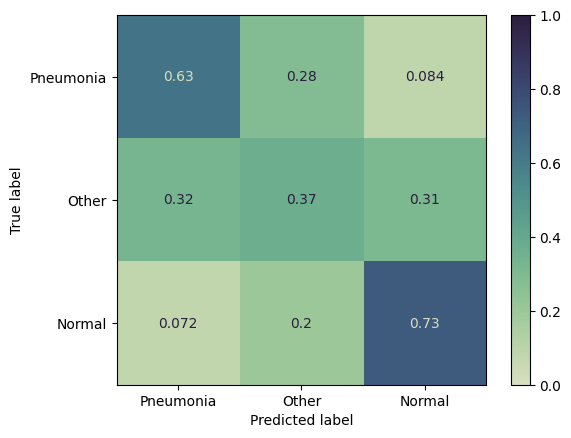

In [23]:
LABELS = ["Pneumonia", "Other", "Normal"]
CMAP = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)

disp_1 = ConfusionMatrixDisplay.from_estimator(HistGB, X_test, y_test, display_labels=LABELS, cmap=CMAP, normalize="true")
disp_1.im_.set_clim(0, 1)

## Третий виток: Обычный градиентный бустинг + optuna

In [24]:
df_images = pd.read_csv(DATA_FOLDER + "data_FEB25_SVD_eq_sample_128_5000.csv").iloc[:, 1:]
# df_images = pd.read_csv(DATA_FOLDER + "data_DEC24_SVD_128_5000.csv").iloc[:, 1:]

print(f"Размер выборки: {df_images.shape[0]}")

X, y = df_images.drop(columns="class"), df_images["class"]
X.head(4)

Размер выборки: 5001


,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,-6223,9927,3067,21008,-29338,-10909,1422,4398,425,-6796,...,1315,405,1050,-1212,373,105,-413,-286,152,1342
1,36388,32262,18336,1356,7981,-9171,-3858,-7075,-15646,-4055,...,228,-382,404,-247,205,-28,-2351,-240,-1443,-801
2,-23148,20247,218,11207,5652,3891,16990,7596,-2685,6401,...,-2723,613,550,282,340,521,2654,-809,-976,-63
3,-30978,12287,-23751,-123,6314,14986,-3674,1458,-3767,2653,...,93,775,-141,228,2113,-364,-1409,341,997,559


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

In [26]:
GradBoost = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', GradientBoostingClassifier(random_state=random_state))
])

GradBoost.fit(X_train, y_train)

y_pred_GradBoost = GradBoost.predict(X_test)
get_metrics(y_pred_GradBoost, y_test)

Balanced accuracy: 0.5550736
F1-score: 0.57585235
roc_auc_score: 0.67564213
gini_score:0.35128426


Текущая стратегия: взять примерно все параметры какие есть и посмотреть их широко. Затем сужаем поиски, задаём категариальные паарметры.

In [27]:
def objective03(trial):
    criterion = trial.suggest_categorical('criterion', ['friedman_mse', 'squared_error'])
    lr = trial.suggest_float('learning_rate', 1e-2, 1e-1/2, log=True)
    n_estimators = trial.suggest_int('n_estimators', 200, 500)
    max_depth = trial.suggest_int('max_depth', 50, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 75, 200)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 75, 150)

    model = GradientBoostingClassifier(
        random_state=random_state,
        criterion=criterion,
        max_features='sqrt',
        learning_rate = lr, 
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split = min_samples_split,
        min_samples_leaf = min_samples_leaf,

    )
    return evaluate_model(model)

In [28]:
study03 = optuna.create_study(
    study_name="third_study",
    direction='minimize',
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.HyperbandPruner()
)

study03.optimize(objective03, n_trials=50, n_jobs=-1, )

[I 2025-03-14 21:13:36,338] A new study created in memory with name: third_study
[I 2025-03-14 21:14:10,200] Trial 3 finished with value: 0.8819551191745398 and parameters: {'criterion': 'squared_error', 'learning_rate': 0.017033777891437774, 'n_estimators': 231, 'max_depth': 57, 'min_samples_split': 120, 'min_samples_leaf': 75}. Best is trial 3 with value: 0.8819551191745398.
[I 2025-03-14 21:14:15,935] Trial 2 finished with value: 0.8856358578117585 and parameters: {'criterion': 'squared_error', 'learning_rate': 0.013680415621450533, 'n_estimators': 346, 'max_depth': 73, 'min_samples_split': 188, 'min_samples_leaf': 131}. Best is trial 3 with value: 0.8819551191745398.
[I 2025-03-14 21:14:19,272] Trial 1 finished with value: 0.890700838795786 and parameters: {'criterion': 'squared_error', 'learning_rate': 0.010828864130122117, 'n_estimators': 372, 'max_depth': 56, 'min_samples_split': 96, 'min_samples_leaf': 127}. Best is trial 3 with value: 0.8819551191745398.
[I 2025-03-14 21:14:19

In [29]:
oviz.plot_param_importances(study03)

In [30]:
fig = optuna.visualization.plot_contour(study03)
fig.update_layout(
    width=1000,
    height=1000
)

In [31]:
study03.best_params

{'criterion': 'friedman_mse',
 'learning_rate': 0.019177395406836977,
 'n_estimators': 460,
 'max_depth': 96,
 'min_samples_split': 142,
 'min_samples_leaf': 105}

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

GradBoost = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', GradientBoostingClassifier(
        random_state=random_state, 
        max_features='sqrt',
        **study03.best_params
    ))
])

GradBoost.fit(X_train, y_train)

y_pred_GradBoost = GradBoost.predict(X_test)
get_metrics(y_pred_GradBoost, y_test)

Balanced accuracy: 0.56759994
F1-score: 0.57899825
roc_auc_score: 0.68088127
gini_score:0.36176254


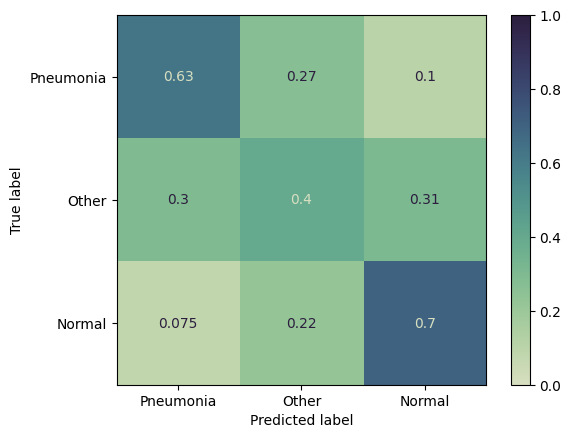

In [33]:
LABELS = ["Pneumonia", "Other", "Normal"]
CMAP = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)

disp_1 = ConfusionMatrixDisplay.from_estimator(GradBoost, X_test, y_test, display_labels=LABELS, cmap=CMAP, normalize="true")
disp_1.im_.set_clim(0, 1)

* Качество лучшей модели не было пробито

* Побор параметров заканчивается с gini 0.35-0.38

`Получается, из этого датасета мы выжали всё что смогли. Дальше другая предобработка и deep learning...`